In [6]:
import pandas as pd
import numpy as np
import warnings
import mrmr
import json 
warnings.filterwarnings("ignore")

In [7]:
# Define the list of feature names
feature_names =  ['age', 'rank', 'height', 'weight', 'bmi', 'bp_s', 'bp_d', 'bp', 'map', 'smoker', 'alcohol', 'faam', 'eilp', 'chronicity', 'ttp', 'ttd', 'ttt', 'wait time', 'time_dg', 'co_morb', 'prior_injuries', 'prior_surgery', 'prior_courses']

# Read the feature data from a CSV file into a Pandas DataFrame
X = pd.read_csv('data//X.csv', header=None)

# Assign the feature names to the columns of the DataFrame
X.columns = feature_names

# Read the target variable (labels) from a CSV file into a Pandas DataFrame
y = pd.read_csv('data//y.csv', header=None)

# Assign a column name ('labels') to the target variable
y.columns = ['labels']

# Use the mrmr_classif function to select features based on minimum redundancy maximum relevance
selected_features = mrmr.mrmr_classif(X, y.iloc[:, 0].values, K=X.shape[1])

# Initialize a list with the first selected feature
valid_features = [selected_features[0]]

# Iterate over the remaining selected features and check for correlation with already selected features
for feat in range(1, X.shape[1]):
    # Check if the absolute correlation between the current feature and the valid features is greater than 0.5
    if any(abs(X[valid_features + [selected_features[feat]]].corr().iloc[:-1, -1].values) > 0.5):
        # If the correlation is greater than 0.5, skip adding the feature to the valid features list
        pass
    else:
        # If the correlation is not greater than 0.5, add the feature to the valid features list
        valid_features.append(selected_features[feat])

# Create a new DataFrame (X_) containing only the selected valid features
X_ = X[valid_features].copy()

100%|██████████| 23/23 [00:08<00:00,  2.83it/s]


In [8]:
from sklearn.linear_model import LogisticRegression
from AITIA.uncertainty_system import UncertaintyEstimator
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

In [9]:
model = LogisticRegression(class_weight='balanced',C=0.25,penalty='l2',solver='liblinear')

In [10]:
X_synth = X_.values
y_synth = y['labels'].values

In [12]:
uncertainty_estimator = UncertaintyEstimator(model, kneighbors_n=5, max_depth=4, rdos_neighbors=5, balanced=True, categorical_idx=[2,3,7,9,10,14,15])
uncertainty_estimator = UncertaintyEstimator(model)

# Create StratifiedKFold object for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

# Iterate through threshold values from 99 to 0
for threshold_ in range(500, -1, -10):
    threshold = threshold_ / 1000.0
    results[threshold] = []

for train_index, val_index in skf.split(X_synth, y_synth):
    X_train, X_val = X_synth[train_index], X_synth[val_index]
    y_train, y_val = y_synth[train_index], y_synth[val_index]

    # Fit uncertainty estimator on training data
    print('fitting')
    uncertainty_estimator.fit(X_train, y_train)

    # Make predictions on the validation set
    print('predicting')
    y_pred, y_prob, uncertainty = uncertainty_estimator.predict(X_val, return_predictions=True)

    for threshold_ in range(500, -1, -10):
        threshold = threshold_ / 1000.0

        # Check if all classes are present in the subset below the threshold
        if all([c in y_val[uncertainty < threshold] for c in np.unique(y_val)]):

            # Calculate the score based on the specified evaluation metric
            score = metrics.roc_auc_score(y_val[uncertainty < threshold], y_prob[uncertainty < threshold, 1])
            results[threshold].append(score)

fitting
predicting
fitting
predicting
fitting
predicting
fitting
predicting
fitting
predicting


In [16]:
with open("abstention_results.json", 'r') as json_file:
    results = json.load(json_file)

In [18]:
mean_score = []
thresh = []
for k, v in results.items():
    if v != []:
        mean_score.append(np.mean(v))
        thresh.append(float(k))

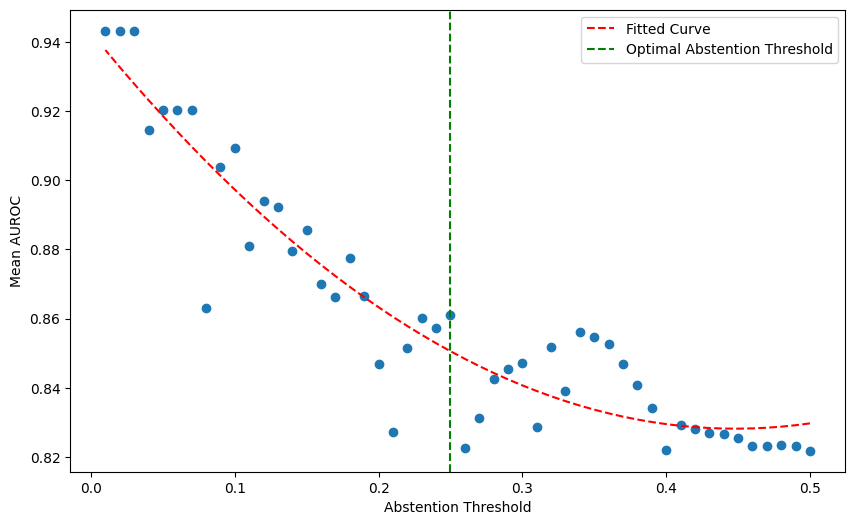

In [19]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the model function to fit (in this case, a quadratic function)
def quadratic_function(x, a, b, c):
    return a * x**2 + b * x + c

# Fit the curve to the data
params, covariance = curve_fit(quadratic_function, thresh, mean_score)

# Extract the coefficients
a, b, c = params

# Generate sampled points
sample_points_x = np.arange(0, 0.51, 0.01)
sample_points_y = quadratic_function(sample_points_x, a, b, c)

# Set the figure size
plt.figure(figsize=(10, 6)) 

# Plot the original data and the fitted curve
plt.scatter(thresh, mean_score)
plt.plot(thresh, quadratic_function(np.array(thresh), a, b, c), '--', color='red', label='Fitted Curve')

# Add a vertical line at where AUROC first exceed 0.85
plt.axvline(x=sample_points_x[np.where(sample_points_y > 0.85)[0][-1]], color='green', linestyle='--', label='Optimal Abstention Threshold')

# Display the plot
plt.legend()
plt.xlabel('Abstention Threshold')
plt.ylabel('Mean AUROC')
plt.show()